
# Load the various utility libraries

This is written as if you were running the notebook within a pull of my notebooks repository from a Microsoft Windows operating system.

In [1]:

import sys

# Install the pygraphviz library
!{sys.executable} -m pip install pygraphviz --upgrade --quiet

In [3]:

# Install the bs4 library
!{sys.executable} -m pip install bs4 --upgrade --quiet

In [4]:

# Install the wikipedia library
!{sys.executable} -m pip install wikipedia --upgrade --quiet


# Prepare the directional graph for adding nodes and edges to

In [6]:

# https://www.reddit.com/r/Jung/comments/8105jh/i_scraped_wikipedia_to_build_jungian_influence/duzirxw/
import pygraphviz as pgv
from bs4 import BeautifulSoup as bs
import wikipedia

In [7]:

# Navigate the infobox links
PAGEID_DICT = {'James Hutton': 15965, 'Plato': 22954, 'Alan Watts': 202475, 'Dan Harmon': 4749267,
               'Jordan Peterson': 30483032}
def spider_infoboxes(jung_digraph, wiki_page, updown='both'):
    wiki_soup = bs(wiki_page.html(), 'html.parser')
    wiki_title = wiki_page.title
    for param_th in wiki_soup.find_all('th', scope='row'):
        if (param_th.text.strip()=='Influences') and ((updown=='both') or (updown=='up')):
            influences_td = param_th.find_next_sibling('td')
            for influences_link in influences_td.find_all('a', title=True):
                influences_title = influences_link['title']
                
                # Compensate for redirects
                try:
                    if influences_title in PAGEID_DICT:
                        influences_page = wikipedia.page(pageid=PAGEID_DICT[influences_title])
                    else:
                        influences_page = wikipedia.page(title=influences_title)
                    influences_title = influences_page.title

                    if influences_title not in NODE_LIST:
                        jung_digraph.add_node(influences_title)
                    jung_digraph.add_edge(influences_title, wiki_title)
                    if influences_title not in NODE_LIST:
                        jung_digraph = spider_infoboxes(jung_digraph, influences_page, updown='up')
                        NODE_LIST.append(influences_title)
                except Exception as e:
                    print(str(e).strip())
                    PAGEID_DICT[influences_title] = influences_title
        if (param_th.text.strip()=='Influenced') and ((updown=='both') or (updown=='down')):
            influenced_td = param_th.find_next_sibling('td')
            for influenced_link in influenced_td.find_all('a', title=True):
                influenced_title = influenced_link['title']
                
                # Compensate for redirects
                try:
                    if influenced_title in PAGEID_DICT:
                        influenced_page = wikipedia.page(pageid=PAGEID_DICT[influenced_title])
                    else:
                        influenced_page = wikipedia.page(title=influenced_title)
                    influenced_title = influenced_page.title

                    if influenced_title not in NODE_LIST:
                        jung_digraph.add_node(influenced_title)
                    jung_digraph.add_edge(wiki_title, influenced_title)
                    if influenced_title not in NODE_LIST:
                        jung_digraph = spider_infoboxes(jung_digraph, influenced_page, updown='down')
                        NODE_LIST.append(influenced_title)
                except Exception as e:
                    print(str(e).strip())
                    PAGEID_DICT[influenced_title] = influenced_title
    
    return jung_digraph


# Add the nodes and edges

In [12]:

import os

dot_dir = r'../saves/dot'
file_path = os.path.join(dot_dir, 'jung_digraph_dot.dot')
if os.path.isfile(file_path):
    jung_digraph = pgv.AGraph(file_path)
else:
    
    # Strict (no parallel edges) digraph
    # with attribute rankdir set to 'LR'
    jung_digraph = pgv.AGraph(directed=True, strict=True, rankdir='LR')
    
    jung_title = 'Carl Jung'
    NODE_LIST = [jung_title]
    jung_digraph.add_node(jung_title)
    jung_page = wikipedia.page(jung_title)
    jung_digraph = spider_infoboxes(jung_digraph, jung_page)
    
    # You have to view the page by source and do something like
    # (wgArticleId|wgRelevantArticleId|idhash)"?:\d+
    # to find out what the page id is (and update PAGEID_DICT with it)
    print(PAGEID_DICT)


# Explore various graph visualizations

In [10]:

progs_list = ['neato', 'dot', 'twopi', 'circo']
progs_list.reverse()
formats_list = ['png', 'svg', 'dot']
for fmt in formats_list:
    dir_path = os.path.join('..', 'saves', fmt)
    os.makedirs(name=dir_path, exist_ok=True)
    for prog in progs_list:
        file_name = f'jung_digraph_{prog}.{fmt}'
        file_path = os.path.join(dir_path, file_name)
        if not os.path.isfile(file_path):
            try:
                jung_digraph.layout(prog)
                jung_digraph.draw(file_path, format=fmt, prog=prog)
            except Exception as e:
                message = str(e).strip()
                if len(message) > 80:
                    message = f'{message[:80]}...'
                print(f'Got this when trying to save as {file_name}: {message}')

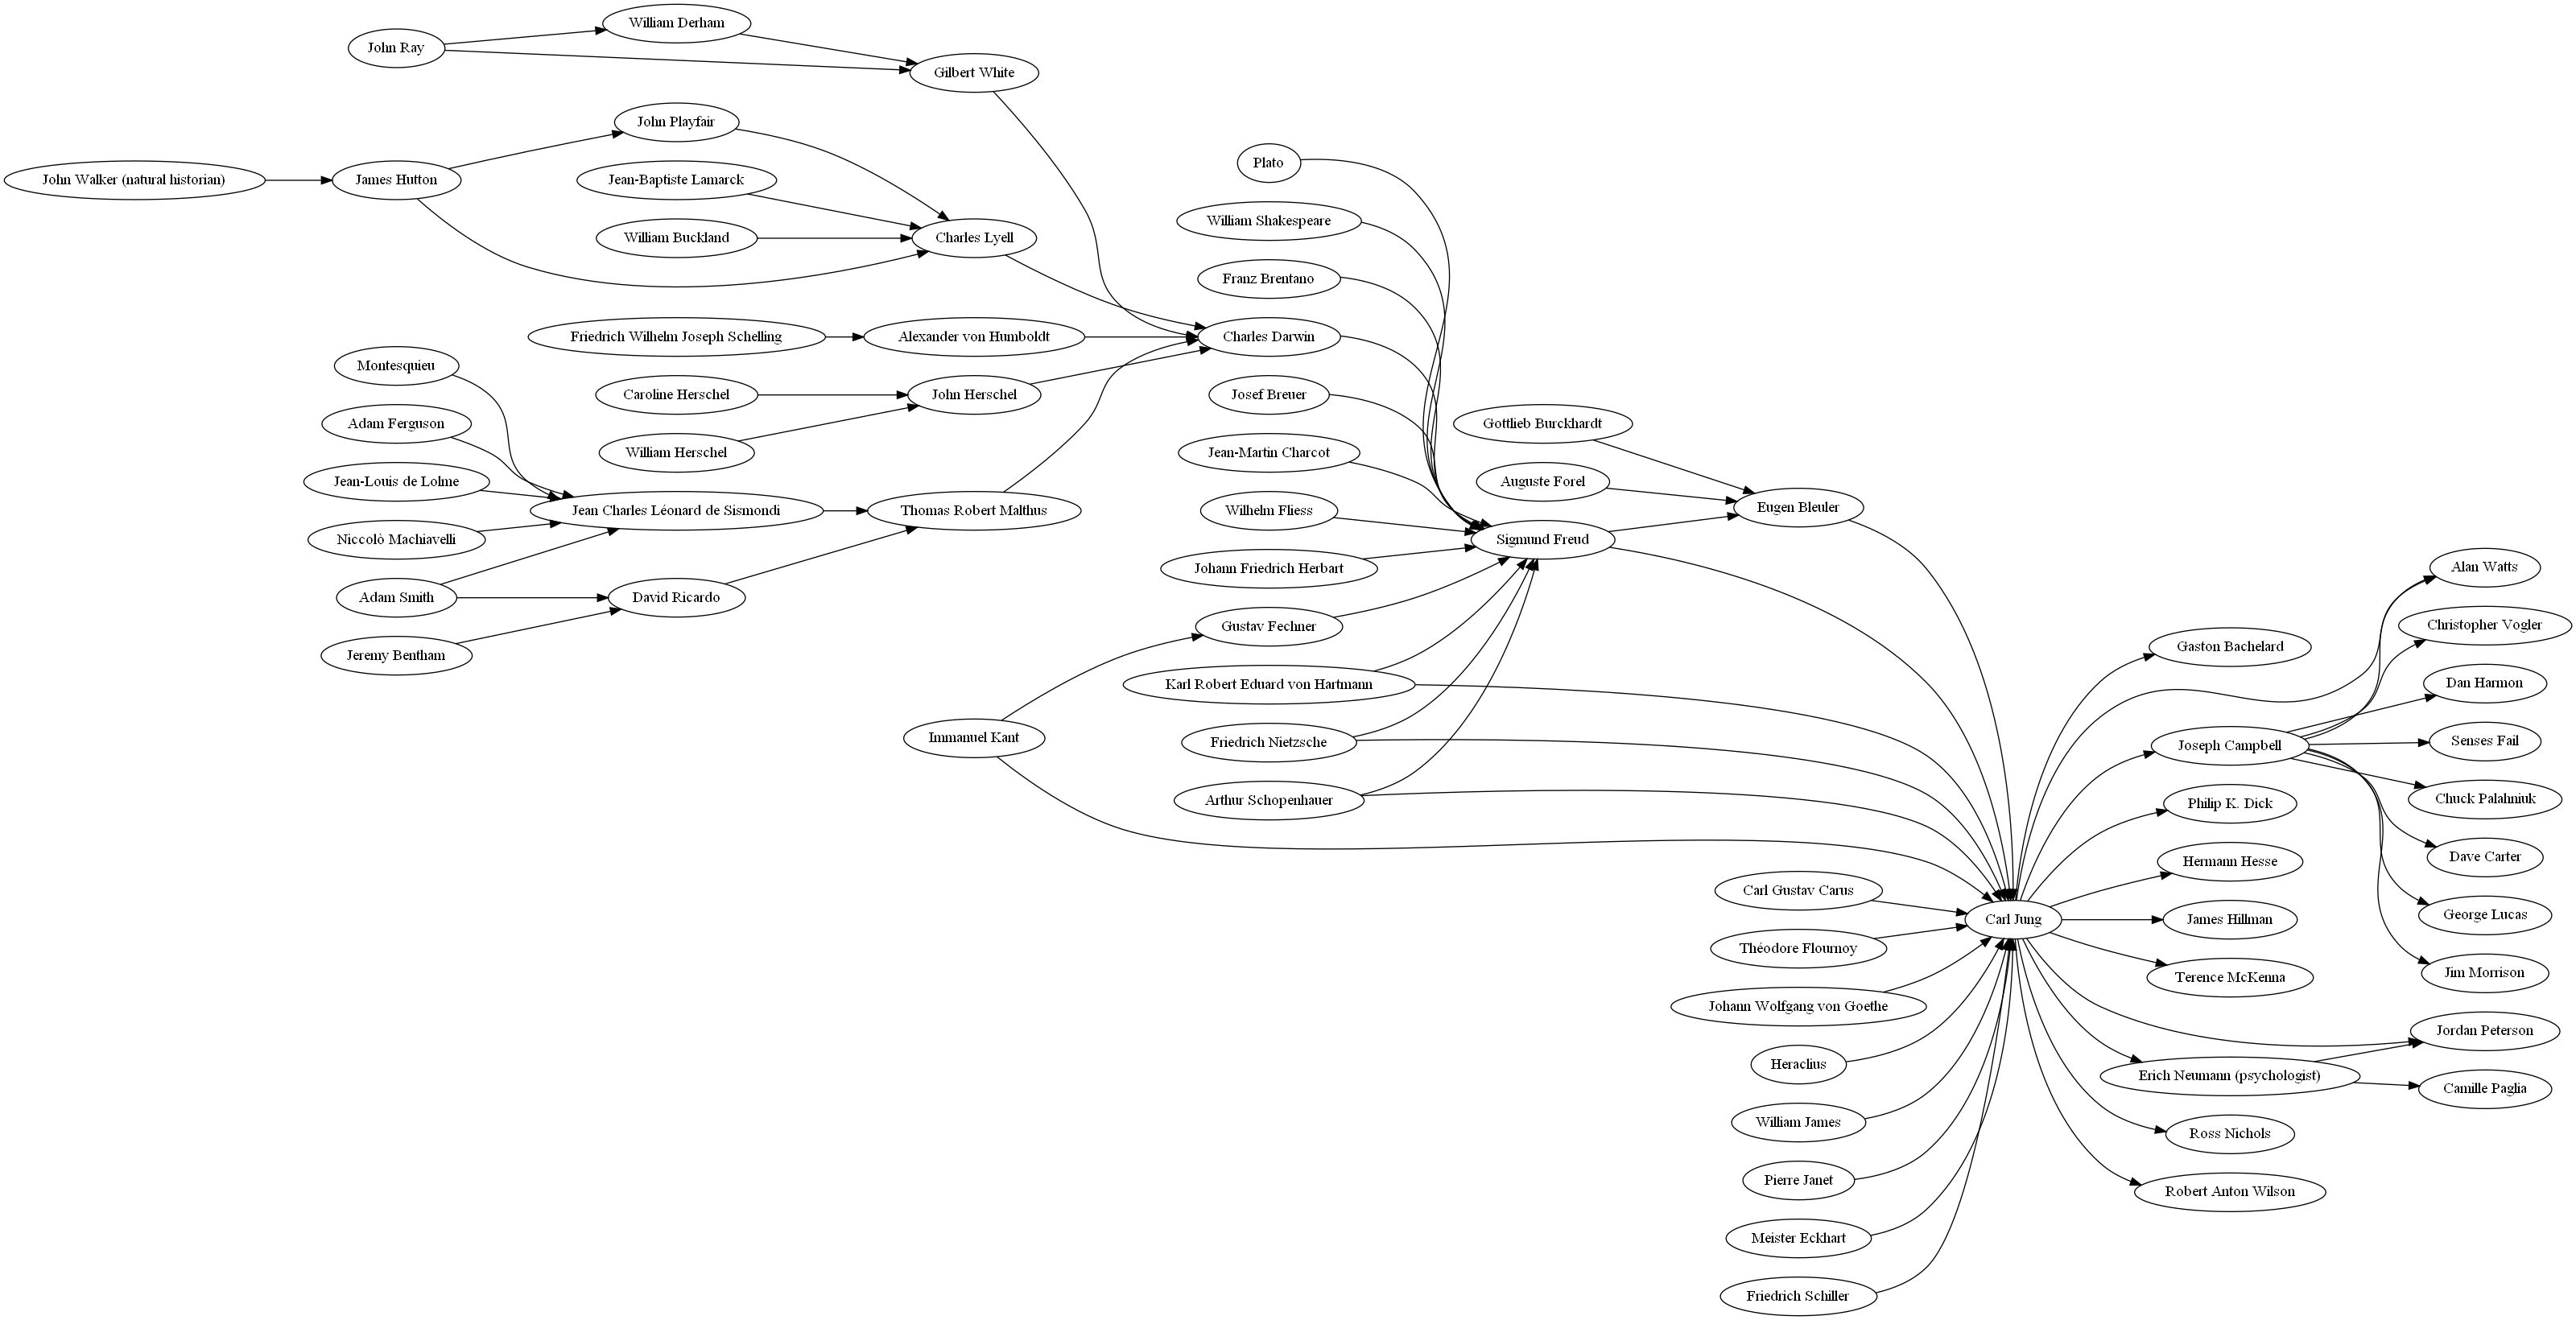

In [11]:

from IPython.display import Image

Image(filename='../saves/png/jung_digraph_dot.png') 

In [20]:

import networkx as nx

nx.nx_agraph.from_agraph(jung_digraph)